# Installation

# Imports

In [61]:
import atexit
import csv
import tempfile
import time
import warnings
from collections import deque
from contextlib import contextmanager
from pathlib import Path

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import pyarrow.parquet as pq
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from scipy import stats
from torch import optim
from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader
from torch_geometric.nn import ChebConv, EdgeConv, GATConv, GCNConv
from torch_geometric.nn.inits import reset
from torch_geometric.utils import add_self_loops, remove_self_loops, scatter_

In [16]:
import proteinsolver
import proteinsolver.datasets

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

# Properties

In [184]:
UNIQUE_ID = "oldxxx"

In [19]:
NOTEBOOK_NAME = "protein_analysis"

In [20]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/protein_analysis')

# Datasets

In [21]:
DATA_ROOT = Path(tempfile.gettempdir())
DATA_ROOT = Path("/home/strokach/ml_data")
DATA_ROOT.mkdir(exist_ok=True)
DATA_ROOT

PosixPath('/home/strokach/ml_data')

## Protein

In [22]:
protein_dataset_train_0 = proteinsolver.datasets.ProteinDataset(root=DATA_ROOT / "protein_train_0", subset="train_0")

In [23]:
protein_dataset_train_1 = proteinsolver.datasets.ProteinDataset(root=DATA_ROOT / "protein_train_1", subset="train_1")

In [24]:
# protein_dataset_train_2 = proteinsolver.datasets.ProteinDataset(root=DATA_ROOT / "protein_train_2", subset="train_2")

In [25]:
protein_dataset_valid = proteinsolver.datasets.ProteinInMemoryDataset(root=DATA_ROOT / "protein_valid", subset="valid")

In [26]:
protein_dataset_test = proteinsolver.datasets.ProteinInMemoryDataset(root=DATA_ROOT / "protein_test", subset="test")

In [27]:
file = "/home/kimlab1/database_data/datapkg_output_dir/adjacency-net-v2/master/validation_dataset_wdistances/adjacency_matrix.parquet/database_id=G3DSA%3A2.40.155.10/part-00000-d5e89475-69dd-45c6-9a80-5bf751fce422-c000.snappy.parquet"
protein_dataset_gfp = proteinsolver.datasets.ProteinInMemoryDataset(root=DATA_ROOT / "protein_gfp", subset="gfp", data_url=file)

## Protherm

In [28]:
file = "/home/kimlab1/database_data/datapkg_output_dir/adjacency-net-v2/master/protherm_dataset/protherm_validaton_dataset.parquet"
extra_columns = ["qseq", "residue_idx_1_corrected", "residue_idx_2_corrected", "distances"]
extra_column_renames = {
    "qseq": "sequence",
    "residue_idx_1_corrected": "row_index",
    "residue_idx_2_corrected": "col_index",
}
protherm_dataset = proteinsolver.datasets.ProteinInMemoryDataset(
    root=DATA_ROOT / "protherm",
    subset="",
    data_url=file,
    extra_columns=extra_columns,
    extra_column_renames=extra_column_renames,
)
protherm_df = pq.read_table(file).to_pandas()

In [29]:
protherm_dataset[0]

Data(Index=[1], edge_attr=[7356, 2], edge_index=[2, 7356], x=[162])

In [30]:
protherm_df.head(2)

,filename_wt,chain_id,mutation,cartesian_ddg_beta_nov15_cart_1,ddg_exp,cartesian_ddg_beta_nov16_cart_1,cartesian_ddg_score12_cart_1,cartesian_ddg_talaris2013_cart_1,cartesian_ddg_talaris2014_cart_1,ddg_monomer_soft_rep_design_1,local_filename_wt,structure_id,model_id,qseq,residue_idx_1_corrected,residue_idx_2_corrected,distances,mutation_matches_sequence,qseq_mutation
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 66, 70, 91...","[1.3463744749991646, 4.7287436401778065, 6.389...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 66, 70, 91, 92...","[1.345760255620924, 4.727237880524551, 6.42311...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...


## Sudoku

In [31]:
# sudoku_dataset_train = proteinsolver.datasets.SudokuDataset2(root=DATA_ROOT.joinpath("sudoku_train"), subset="train")

In [32]:
# sudoku_dataset_valid = proteinsolver.datasets.SudokuDataset2(root=DATA_ROOT.joinpath("sudoku_valid"), subset="valid")

# Models

In [33]:
class EdgeConvMod(torch.nn.Module):
    def __init__(self, nn, aggr="max"):
        super().__init__()
        self.nn = nn
        self.aggr = aggr
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)

    def forward(self, x, edge_index, edge_attr=None):
        """"""
        row, col = edge_index
        x = x.unsqueeze(-1) if x.dim() == 1 else x

        # TODO: Try -x[col] instead of x[col] - x[row]
        if edge_attr is None:
            out = torch.cat([x[row], x[col]], dim=-1)
        else:
            out = torch.cat([x[row], x[col], edge_attr], dim=-1)
        out = self.nn(out)
        x = scatter_(self.aggr, out, row, dim_size=x.size(0))

        return x, out

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.nn)

In [34]:
class EdgeConvBatch(nn.Module):
    def __init__(self, gnn, hidden_size, batch_norm=True, dropout=0.2):
        super().__init__()

        self.gnn = gnn

        x_post_modules = []
        edge_attr_post_modules = []

        if batch_norm is not None:
            x_post_modules.append(nn.LayerNorm(hidden_size))
            edge_attr_post_modules.append(nn.LayerNorm(hidden_size))

        if dropout:
            x_post_modules.append(nn.Dropout(dropout))
            edge_attr_post_modules.append(nn.Dropout(dropout))

        self.x_postprocess = nn.Sequential(*x_post_modules)
        self.edge_attr_postprocess = nn.Sequential(*edge_attr_post_modules)

    def forward(self, x, edge_index, edge_attr=None):
        x, edge_attr = self.gnn(x, edge_index, edge_attr)
        x = self.x_postprocess(x)
        edge_attr = self.edge_attr_postprocess(edge_attr)
        return x, edge_attr

In [35]:
def get_graph_conv_layer(input_size, hidden_size, output_size):
    mlp = nn.Sequential(
        #
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
    )
    gnn = EdgeConvMod(nn=mlp, aggr="add")
    graph_conv = EdgeConvBatch(gnn, output_size, batch_norm=True, dropout=0.2)
    return graph_conv

In [36]:
class Net(nn.Module):
    def __init__(self, x_input_size, adj_input_size, hidden_size, output_size):
        super().__init__()

        self.embed_x = nn.Sequential(
            nn.Embedding(x_input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
#             nn.ReLU(),
        )

        if adj_input_size:
            self.embed_adj = nn.Sequential(
                nn.Linear(adj_input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.LayerNorm(hidden_size),
#                 nn.ELU(),
            )
        else:
            self.embed_adj = None

        self.graph_conv_1 = get_graph_conv_layer((2 + bool(adj_input_size)) * hidden_size, 2 * hidden_size, hidden_size)
        self.graph_conv_2 = get_graph_conv_layer(3 * hidden_size, 2 * hidden_size, hidden_size)
        self.graph_conv_3 = get_graph_conv_layer(3 * hidden_size, 2 * hidden_size, hidden_size)
        self.graph_conv_4 = get_graph_conv_layer(3 * hidden_size, 2 * hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, edge_attr=None):

        x = self.embed_x(x)
        edge_index, _ = remove_self_loops(edge_index)  # We should remove self loops in this case!
        edge_attr = self.embed_adj(edge_attr) if edge_attr is not None else None

        x_out, edge_attr_out = self.graph_conv_1(x, edge_index, edge_attr)
        x += x_out
        edge_attr = (edge_attr + edge_attr_out) if edge_attr is not None else edge_attr_out

        x = F.relu(x)
        edge_attr = F.relu(edge_attr)
        x_out, edge_attr_out = self.graph_conv_2(x, edge_index, edge_attr)
        x += x_out
        edge_attr += edge_attr_out

        x = F.relu(x)
        edge_attr = F.relu(edge_attr)
        x_out, edge_attr_out = self.graph_conv_3(x, edge_index, edge_attr)
        x += x_out
        edge_attr += edge_attr_out

        x = F.relu(x)
        edge_attr = F.relu(edge_attr)
        x_out, edge_attr_out = self.graph_conv_4(x, edge_index, edge_attr)
        x += x_out
        edge_attr += edge_attr_out

        x = self.linear_out(x)
        return x

In [37]:
@contextmanager
def eval_net(net: nn.Module):
    training = net.training
    try:
        net.train(False)
        yield
    finally:
        net.train(training)


def get_stats_on_missing(data, output):
    mask = (data.x == num_features).squeeze()
    output_missing = output[mask]
    _, predicted_missing = torch.max(output_missing.data, 1)
    return (predicted_missing == data.y[mask]).sum().item(), len(predicted_missing)


def get_data_x(data, frac_present):
    x = torch.where(
        torch.rand(data.y.size(0), device=data.y.device) < frac_present,
        data.y,
        torch.ones(1, dtype=torch.long, device=data.y.device) * num_features,
    )
    return x

# Training plots

In [38]:
training_logs = {}

In [40]:
training_logs["protein_4xEdgeConv_bs4"] = pd.read_csv("protein_4xEdgeConv_bs4/training.log", skiprows=1)
training_logs["protein_4xEdgeConv_bs4"].head(2)

,epoch,step,datapoint,avg_loss,accuracy,accuracy_m,accuracy_mv,time_elapsed
0,0,512.0,1024.0,NaN,0.071873,0.071566,0.073593,32.928715
1,0,1024.0,2048.0,NaN,0.073939,0.074984,0.072040,32.352520


In [41]:
plt.style.available

['seaborn',
 'bmh',
 'dark_background',
 'Solarize_Light2',
 'fast',
 'ggplot',
 'seaborn-whitegrid',
 'grayscale',
 'seaborn-deep',
 'seaborn-paper',
 'classic',
 'seaborn-darkgrid',
 'seaborn-white',
 'seaborn-dark-palette',
 'tableau-colorblind10',
 'seaborn-bright',
 'seaborn-poster',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-muted',
 'seaborn-colorblind',
 '_classic_test',
 'seaborn-pastel',
 'seaborn-notebook',
 'seaborn-talk',
 'seaborn-dark']

In [29]:
# plt.style.use('seaborn-notebook')

In [45]:
cmap = cm.get_cmap("tab10")

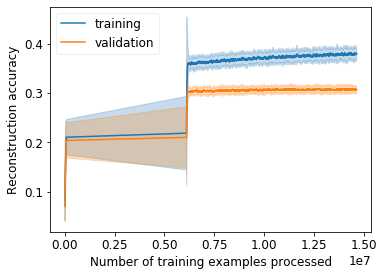

In [46]:
window = 30
df = training_logs["protein_4xEdgeConv_bs4"]

# with plt.rc_context(rc={"font.size": 12}):
fg, ax = plt.subplots(figsize=(5.5, 4))
x = df["datapoint"]
accuracy_m_mean, accuracy_m_std = df["accuracy_m"].ewm(com=16, min_periods=0).agg(['mean', 'std']).values.T
accuracy_mv_mean, accuracy_mv_std = df["accuracy_mv"].ewm(com=16, min_periods=0).agg(['mean', 'std']).values.T
ax.plot(x, accuracy_m_mean, label="training", color=cmap(0))
ax.fill_between(x, accuracy_m_mean - accuracy_m_std * 2, accuracy_m_mean + accuracy_m_std * 2, alpha=0.25, color=cmap(0))
ax.plot(x, accuracy_mv_mean, label="validation", color=cmap(1))
ax.fill_between(x, accuracy_mv_mean - accuracy_mv_std * 2, accuracy_mv_mean + accuracy_mv_std * 2, alpha=0.25, color=cmap(1))
#     ax.set_ylim(0.05, 0.45)
ax.set_xlabel("Number of training examples processed")
ax.set_ylabel("Reconstruction accuracy")
ax.ticklabel_format(axis="x", style="scientific", scilimits=(0, 0))
ax.legend(framealpha=0.3)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath("training_curve.svg"))
fg.savefig(NOTEBOOK_PATH.joinpath("training_curve.pdf"))
fg.savefig(NOTEBOOK_PATH.joinpath("training_curve.png"), dpi=300)

# Test set sequence identity

In [47]:
# Parameters
device = torch.device("cuda:0")
# device = "cpu"
batch_size = 4
num_features = 20
adj_input_size = 2
hidden_size = 128
frac_present = 0.5
frac_present_valid = frac_present
info_size= 1024

dataloaders = {
    "train_0": DataLoader(protein_dataset_train_0, shuffle=True, num_workers=4, batch_size=batch_size, drop_last=True),
    "train_1": DataLoader(protein_dataset_train_1, shuffle=True, num_workers=4, batch_size=batch_size, drop_last=True),
    "train_2": None,
    "valid": DataLoader(protein_dataset_valid[:128], shuffle=False, num_workers=4, batch_size=1, drop_last=False),
    "test": DataLoader(protein_dataset_test, shuffle=False, num_workers=4, batch_size=1, drop_last=False),

    "gfp_train": DataLoader(protein_dataset_test[:928], shuffle=True, num_workers=4, batch_size=batch_size, drop_last=True),
    "gfp_valid": DataLoader(protein_dataset_test[928:], shuffle=False, num_workers=4, batch_size=1, drop_last=False),
}

print(device)

cuda:0


In [70]:
net = Net(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load("protein_4xEdgeConv_bs4/e12-s1652709-d6610836.state", map_location=device))
net.eval()
net = net.to(device)

### Oneshot

In [54]:
results = []
for i, data in enumerate(DataLoader(protein_dataset_test, shuffle=False, num_workers=4, batch_size=1, drop_last=False)):
    if (i + 1) % 1000 == 0:
        print(i + 1)
    data = data.to(device)
    data.y = data.x
    x_in = torch.ones_like(data.y) * 20
    is_missing = torch.ones(data.y.size(0), dtype=torch.bool)
    output = net(x_in, data.edge_index, data.edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
oneshot_results_df = pd.DataFrame(results)

1000


### Incremental

In [55]:
@torch.no_grad()
def design_protein(net, x, edge_index, edge_attr):
    mask = x == 20
    if not mask.any():
        return x, entropy
    output = net(x, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    max_pred, max_index = output.max(dim=1)
    max_pred[~mask] = -1
    _, max_residue = max_pred.max(dim=0)
    x[max_residue] = max_index[max_residue]
    return design_protein(net, x, edge_index, edge_attr)

In [56]:
test_sequence_identity = {}

In [63]:
frac_present = 0.8

results = []
for i, data in enumerate(tqdm.tqdm_notebook(protein_dataset_test, total=len(protein_dataset_test))):
    data.to(device)
    if frac_present == 0:
        is_present = torch.zeros(data.x.size(0), dtype=torch.bool, device=data.x.device)
        x_in = torch.ones_like(data.x) * 20
    else:
        is_present = torch.rand(data.x.size(0), device=data.x.device) < frac_present
        x_in = torch.where(is_present, data.x, torch.tensor(20, device=data.x.device))
    x_pred = design_protein(net, x_in, data.edge_index, data.edge_attr)
    identity_all = float((x_pred == data.x).sum()) / data.x.size(0)
    identity_missing = float((x_pred[~is_present] == data.x[~is_present]).sum()) / (~is_present).sum().item()
    result = {"identity_all": identity_all, "identity_missing": identity_missing}
    results.append(result)

test_sequence_identity[frac_present] = pd.DataFrame(results)

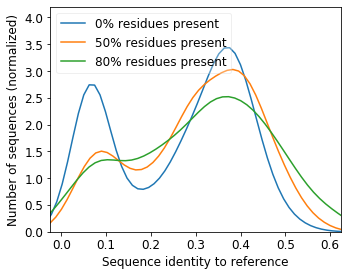

In [190]:
xlim = -0.025, 0.625

fg, ax = plt.subplots(figsize=(5, 4))
for frac, df in sorted(test_sequence_identity.items()):
    data = df["identity_missing"]
    data = np.clip(data, *xlim)
#         ax.hist(data, bins=30, range=xlim, histtype="step", label=f"{frac:.0%} missing residues", linewidth=1.5)
    sns.kdeplot(data, gridsize=35, label=f"{frac:.0%} residues present")
ax.set_ylabel("Number of sequences (normalized)")
ax.set_xlabel("Sequence identity to reference")
ax.set_xlim(*xlim)
ax.set_ylim(0, 4.2)
ax.legend(loc="upper left", framealpha=0.3)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-test-incremental_kde.svg"))

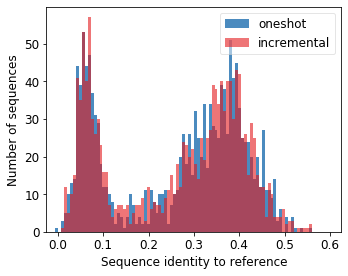

In [189]:
results_df = test_sequence_identity[0]

fg, ax = plt.subplots(figsize=(5, 4))

xlim = -0.025, 0.625

data = oneshot_results_df['fraction_correct']
data = np.clip(data, *xlim)
ax.hist(data, bins=100, range=xlim, alpha=0.9, label="oneshot", histtype='stepfilled', linewidth=2, color=cm.get_cmap("Set1")(1))
# sns.kdeplot(data, gridsize=200, label="oneshot")

data = results_df['identity_missing']
data = np.clip(data, *xlim)
ax.hist(data, bins=100, range=xlim, alpha=0.6, label="incremental", histtype='stepfilled', linewidth=2, color=cm.get_cmap("Set1")(0))
# sns.kdeplot(data, gridsize=100, label="incremental")

ax.set_ylabel("Number of sequences")
ax.set_xlabel("Sequence identity to reference")
ax.set_xlim(xlim)
# ax.set_ylim(0, 165)

ax.legend(framealpha=0.5)

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-test-oneshot-incremental.svg"))

### Protherm validation

In [71]:
results = []

with torch.no_grad():
    for i, data in enumerate(protherm_dataset):
        if (i + 1) % 200 == 0:
            print(i)
        data = data.to(device)

        row = protherm_df.loc[data.Index.item()]
        output = net(data.x, data.edge_index, data.edge_attr)
        output_sm = torch.softmax(output, dim=1)

        wt_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[0].encode()), dtype=torch.long, device=device)
        mut_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[-1].encode()), dtype=torch.long, device=device)
        pos = int(row.mutation[1:-1])
        x_mut = data.x.clone()
        assert x_mut[pos - 1] == wt_idx
        x_mut[pos - 1] = mut_idx
        output_mut = net(x_mut, data.edge_index, data.edge_attr)
        output_mut_sm = torch.softmax(output_mut, dim=1)

        x_blank = data.x.clone()
        assert x_blank[pos - 1] == wt_idx
        x_blank[pos - 1] = 20
        output_blank = net(x_blank, data.edge_index, data.edge_attr)
        output_blank_sm = torch.softmax(output_blank, dim=1)

        result = {
            'wt_wt': output[pos - 1, wt_idx].item(),
            'wt_mut': output[pos - 1, mut_idx].item(),
            'wt_sm_wt': output_sm[pos - 1, wt_idx].item(),
            'wt_sm_mut': output_sm[pos - 1, mut_idx].item(),

            'mut_wt': output_mut[pos - 1, wt_idx].item(),
            'mut_mut': output_mut[pos - 1, mut_idx].item(),
            'mut_sm_wt': output_mut_sm[pos - 1, wt_idx].item(),
            'mut_sm_mut': output_mut_sm[pos - 1, mut_idx].item(),

            'blank_wt': output_blank[pos - 1, wt_idx].item(),
            'blank_mut': output_blank[pos - 1, mut_idx].item(),
            'blank_sm_wt': output_blank_sm[pos - 1, wt_idx].item(),
            'blank_sm_mut': output_blank_sm[pos - 1, mut_idx].item(),

            'ddg_exp': row.ddg_exp,
        }
        results.append(result)

results_df = pd.DataFrame(results)

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399


In [72]:
results_df["blank_change"] = results_df["blank_mut"] - results_df["blank_wt"]
results_df["blank_sm_change"] = results_df["blank_sm_mut"] - results_df["blank_sm_wt"]

results_df["wt_mut_change"] = results_df["mut_mut"] - results_df["wt_wt"]
results_df["wt_mut_sm_change"] = results_df["mut_sm_mut"] - results_df["wt_sm_wt"]

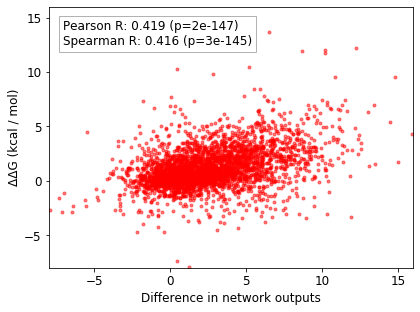

In [188]:
column = "blank_change"
ddg_change = results_df[column].values
ddg_exp = results_df["ddg_exp"].values
textstr = """\
Pearson R: {:.3f} (p={:.0e})
Spearman R: {:.3f} (p={:.0e})
""".format(
    *stats.pearsonr(-ddg_change, ddg_exp), *stats.spearmanr(-ddg_change, ddg_exp)
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4.5))
    ax.plot(-ddg_change, ddg_exp, "r.", alpha=0.5)
    ax.set_xlabel("Difference in network outputs")
    ax.set_ylabel("ΔΔG (kcal / mol)")
    ax.set_xlim(-8, 16)
    ax.set_ylim(-8, 16)
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-protherm-all.svg"))

### Perplexities

In [158]:
def calculate_perplexity(net, x, edge_index, edge_attr, x_in=None):
    if x_in is None:
        x_in = torch.ones_like(x) * 20

    mask = x_in == 20

    if not mask.any().item():
        return []

    output = net(x_in, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)

    probas = output.gather(1, x.view(-1, 1))
    probas[~mask] = -1

    max_proba, max_residue = probas.max(dim=0)
    x_in[max_residue] = x[max_residue]

    return [max_proba.item()] + calculate_perplexity(net, x, edge_index, edge_attr, x_in=x_in)

In [164]:
proba_lists = []
for i, data in enumerate(tqdm.tqdm_notebook(protein_dataset_test, total=len(protein_dataset_test))):
    data = data.to(device)
    with torch.no_grad():
        proba_lst = calculate_perplexity(net, data.x, data.edge_index, data.edge_attr)
    assert len(proba_lst) == data.x.size(0)
    proba_lists.append(proba_lst)

In [179]:
perplexities = [2 ** -(np.log2(proba_lst).mean()) for proba_lst in proba_lists]
print(np.mean(perplexities))

9.980654072504002


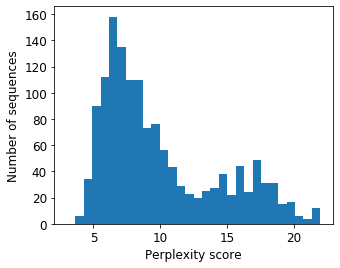

In [186]:
fg, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.clip(perplexities, 3, 22), bins=30, range=(3, 22))
ax.set_xlabel("Perplexity score")
ax.set_ylabel("Number of sequences")
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-perplexity.svg"))

In [ ]:
raise Exception("Done!")

In [49]:
results = []

for i, data in enumerate(protherm_dataset):
    if (i + 1) % 200 == 0:
        print(i)
    row = protherm_df.loc[data.Index.item()]
    data = data.to(device)

    with torch.no_grad():
        log_prob_wt = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

    wt_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[0].encode()), dtype=torch.long, device=device)
    mut_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[-1].encode()), dtype=torch.long, device=device)
    pos = int(row.mutation[1:-1])
    x_mut = data.x.clone()
    assert x_mut[pos - 1] == wt_idx
    x_mut[pos - 1] = mut_idx
    with torch.no_grad():
        log_prob_mut = proteinsolver.utils.get_node_proba(net, x_mut, data.edge_index, data.edge_attr, 20)
        
    results.append(log_prob_mut.sum().item() - log_prob_wt.sum().item())
        
results_df["sum_log_prob_change"] = results

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399


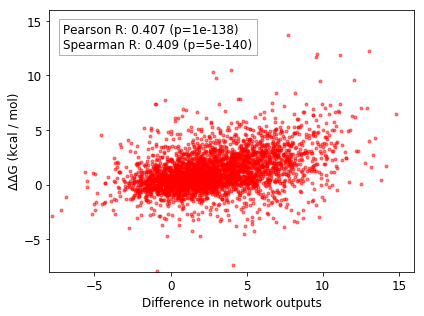

In [50]:
column = "sum_log_prob_change"
ddg_change = results_df[column].values
ddg_exp = results_df["ddg_exp"].values
textstr = """\
Pearson R: {:.3f} (p={:.0e})
Spearman R: {:.3f} (p={:.0e})
""".format(
    *stats.pearsonr(-ddg_change, ddg_exp), *stats.spearmanr(-ddg_change, ddg_exp)
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4.5))
    ax.plot(-ddg_change, ddg_exp, "r.", alpha=0.5)
    ax.set_xlabel("Difference in network outputs")
    ax.set_ylabel("ΔΔG (kcal / mol)")
    ax.set_xlim(-8, 16)
    ax.set_ylim(-8, 16)
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
# fg.savefig(NOTEBOOK_PATH.joinpath("protherm_all.svg"))
# fg.savefig(NOTEBOOK_PATH.joinpath("protherm_all.pdf"))
# fg.savefig(NOTEBOOK_PATH.joinpath("protherm_all.png"), dpi=300)

In [51]:
import pyarrow as pa
import pyarrow.parquet as pq

In [52]:
# table = pa.Table.from_pandas(results_df)
# pq.write_table(table, NOTEBOOK_PATH.joinpath("results.parquet"))